In [1]:
import numpy as np
import pyNN.nest as sim
from pyNN.random import NumpyRNG
from pyNN.random import RandomDistribution as rnd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
import lmfit
import matplotlib.gridspec as gridspec

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/anaconda3/lib/python3.7/site-packages/PyNN-0.9.2-py3.7.egg/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


# Showing that pure hebbian learning rule doesnt work, hence our stdp structure

In [2]:
from pyNN.space import *


class RingTopology(BaseStructure):
    parameter_names = 'radius'

    def __init__(self, radius):
        self.radius = radius

    def generate_positions(self, n):
        return np.array([
            np.cos(np.linspace(0, 2*np.pi, n))+(self.radius-1),
            np.sin(np.linspace(0, 2*np.pi, n))+(self.radius-1),
            np.zeros(n)
        ])
        # must return a 3xn numpy array

In [3]:
def tuning_function(x, j, B, fmax):  # von mises
    N = len(x)
    if B == np.inf:
        VM = np.ones_like(x)
    else:
        VM = np.exp((np.cos(2.*np.pi*(x-j)/N)-1.)/4/(B*np.pi/180)**2)
    #VM /= VM.sum(axis=0)
    return fmax * VM


def fit_plot(popsize, spike_array, ax, datacol='.r', fitcol='--k', data_kws=None, do_title=True,
             seq_nbr=None):
    '''
    calculates a spike array gaussian lmfit profile and plots it
    '''

    # fit the gaussian
    x = np.linspace(0, popsize, popsize)
    y = spike_array
    N = len(spike_array)

    #mod = GaussianModel()
    from lmfit import Model, Parameters
    mod = Model(tuning_function)
    pars = Parameters()
    pars.add_many(('j', y.argmax(), True,  0.0, N), ('B', 15., True,  0.1, 360),
                  ('fmax', y.max(), True,  0.0, 200.))

    #pars = mod.guess(y, x=x)
    #pars['center'] = lmfit.Parameter('center', seq_nbr*15)
    out = mod.fit(y, pars, x=x, nan_policy='omit')
    # print(out.fit_report(min_correl=0.25))

    # plot the fits
    out.plot_fit(ax=ax, datafmt=datacol, fitfmt=fitcol,
                 data_kws=data_kws, show_init=False)

    # eye cancer-triggering lines
    sigma = out.best_values['B']

    if do_title:
        ax.set_title('Sequence #%s -- ' % seq_nbr + r'$\sigma$ = %.2f' % sigma)

    return ax, sigma


def cut_spiketrain(array, window):
    '''
    Cut a spiketrain array between window*500 and window+1 *500
    we use it to only visualize a specific time window of the network
    '''
    spiketrain_len = []
    for spiketrain in np.asarray(array.spiketrains):
        spiketrain_array = np.array(spiketrain, dtype=float)

        spiketrain_cut = np.where(
            (spiketrain_array > window*1250) & (spiketrain_array < (window+1)*1250))[0]

        spiketrain_len.append(len(spiketrain_cut))

    spikelen_array = np.asarray(spiketrain_len)
    return spikelen_array

In [4]:
def SuperPlotter(SpikesP, SpikesE, SpikesI,
                 popsize, simtime,
                 title='Title', markersize=.5,
                 figsize=(9, 6), shifts=None):
    # oh la jolie double fonction
    def plot_spiketrains(ax, spikes, color, ylabel, do_ticks):
        for spiketrain in spikes.spiketrains:
            y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
            ax.scatter(spiketrain, y, color=color, s=markersize)
            ax.set_ylabel(ylabel)
            if not do_ticks:
                ax.set_xticklabels([])
            if shifts != None:
                for i, times in enumerate(shifts):
                    ax.axvline(x=times, color='k',
                               linestyle='-.', linewidth=1)

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(3, 8)
    axs1 = plt.subplot(gs[0, :4])
    axs2 = plt.subplot(gs[1, :4])
    axs3 = plt.subplot(gs[2, :4])

    axs4 = plt.subplot(gs[0:1, 4:6])
    axs5 = plt.subplot(gs[0:1, 6:8])
    axs6 = plt.subplot(gs[1:2, 4:6])
    axs7 = plt.subplot(gs[1:2, 6:8])

    # what a fucking mess
    min_poisson = int(SpikesP.description.split('ID range')[
                      1].split('\n')[0].split(': ')[1].split('-')[0])
    max_poisson = int(SpikesP.description.split('ID range')[
                      1].split('\n')[0].split(': ')[1].split('-')[1])
    axs1.set_ylim(min_poisson, max_poisson)

    plot_spiketrains(axs1, SpikesP, color='g',
                     ylabel='Neuron Index', do_ticks=False)
    axs1.set_title('Poisson input')
    plot_spiketrains(axs2, SpikesI, color='b',
                     ylabel='Neuron Index', do_ticks=False)
    axs2.set_title('Inhibitory population')
    plot_spiketrains(axs3, SpikesE, color='r',
                     ylabel='Neuron Index', do_ticks=True)
    axs3.set_title('Excitatory population')
    axs3.set_xlabel('Time(ms)')

    '''axs1.set_xlim(1250, 1300)
    axs2.set_xlim(1250, 1300)
    axs3.set_xlim(1250, 1300)'''

    axs4.plot(cut_spiketrain(SpikesP, 0), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 0), axs4, seq_nbr=1)[1]
    axs4.set_xticklabels([])
    axs4.set_yticklabels([])
    axs4.set_xlabel('')
    axs4.set_ylabel('')

    axs5.plot(cut_spiketrain(SpikesP, 1), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 1), axs5, seq_nbr=2)[1]
    axs5.set_xticklabels([])
    axs5.set_yticklabels([])
    axs5.set_xlabel('')
    axs5.set_ylabel('')

    axs6.plot(cut_spiketrain(SpikesP, 2), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 2), axs6, seq_nbr=3)[1]
    axs6.set_xticklabels([])
    axs6.set_yticklabels([])
    axs6.set_xlabel('')
    axs6.set_ylabel('')

    axs7.plot(cut_spiketrain(SpikesP, 3), color='g')
    fit_plot(popsize, cut_spiketrain(SpikesE, 3), axs7, seq_nbr=4)[1]
    axs7.set_xlabel('Neuron index')
    axs7.set_ylabel('Sequence spikes', rotation=270)
    axs7.yaxis.tick_right()
    axs7.yaxis.set_label_position("right")

    fig.suptitle(title, fontsize=12)
    plt.show()
    return fig

# Running simulation

In [5]:
n_pop = 60
neuron_parameters = {'cm': .5,  # nF - McCormick
                     'e_rev_E': 0.0,  # mV - McCormick but default values
                     'e_rev_I': -70.0,  # mV - McCormick but default values
                     'tau_m': 30,  # ms - Markram
                     'tau_refrac': 1.5,  # ms - McCormick
                     'tau_syn_E': 0.25,  # ms -McCormick
                     'tau_syn_I': 0.75,  # ms - McCormick
                     'v_reset': -56.5,  # mV - McCormick
                     'v_rest': -65.5,  # mV - McCormick
                     'v_thresh': -52.5,  # mV - McCormick
                     }

simtime = 5000
rng = sim.NumpyRNG(seed=42)

rate_gain = 20.  # multiplier for the rates
angle_input = 40  # degrees
b_theta = 15  # degrees

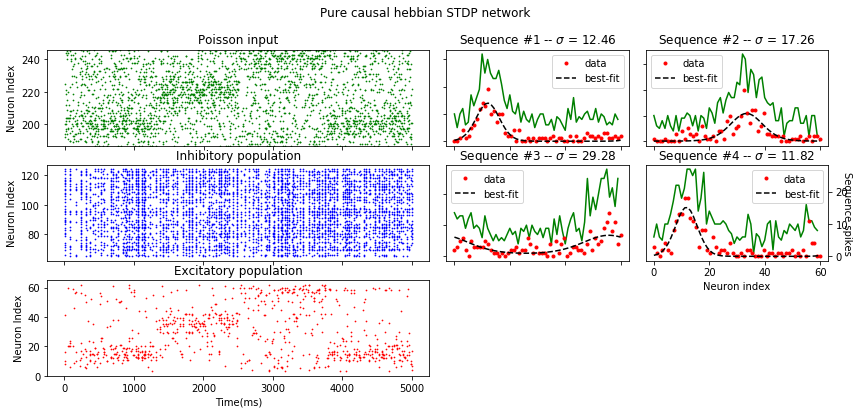

In [11]:
stdp_weight_init = .1
stdp_max_w = 2 * stdp_weight_init
normal_weights = stdp_weight_init

delays = rnd('normal_clipped', mu=3, sigma=5, low=0.1,
             high=5,
             rng=rng)

# la stdp normale
causal_hebian_timing_dependence = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                                    A_plus=.025, A_minus=.025)
# la stdp à l'envers
anticausal_hebian_timing_dependence = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                                        A_plus=-.025, A_minus=-.025)
# la symétrique positive
causal_sym_timing_dependence = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                                 A_plus=.025, A_minus=-.025)
# la symétrique négative
anticausal_sym_timing_dependence = sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                                     A_plus=-.025, A_minus=.025)


sim.setup(timestep=.1, threads=8)
exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                     initial_values={"v": neuron_parameters["v_reset"]},
                     structure=RingTopology(radius=2),
                     label="Neurones Exictateurs")

inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                     initial_values={"v": neuron_parameters["v_reset"]},
                     structure=RingTopology(radius=2),
                     label="Neurones Inhibiteurs")

input_pop = sim.Population(n_pop,
                           sim.SpikeSourcePoisson(
                               rate=1500, duration=simtime, start=0),
                           label="Entree Orientation")
noise_pop = sim.Population(n_pop,
                           sim.SpikeSourcePoisson(
                               rate=5, duration=simtime, start=0),
                           label="Entree Orientation")


# INPUT STDP
in_mult = 4
# input to exc, causal hebbian
in_causal_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=in_mult*stdp_max_w),
    weight=in_mult*stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)
# input to exc, causal hebbian
in_inh_causal_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=-in_mult*stdp_max_w),
    weight=-in_mult*stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)


#causal, exc
causal_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=stdp_max_w),
    weight=stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)
#causal, inh (eg anticausal)
inh_causal_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=-stdp_max_w),
    weight=-stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

# ANTICAUSAL STDP
# syn inh exc, makes the inhibitory fire when exc is not firing
inh_anticausal_STDP_syn = sim.STDPMechanism(
    timing_dependence=anticausal_hebian_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=-stdp_max_w),
    weight=-stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

# SYMETRIC POSITIVE STDP
# syn exc exc, reinforcing
sim_plus_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_sym_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=stdp_max_w),
    weight=stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)
# syn inh inh, reinforcing inhibition
inh_sim_plus_STDP_syn = sim.STDPMechanism(
    timing_dependence=causal_sym_timing_dependence,
    weight_dependence=sim.MultiplicativeWeightDependence(
        w_min=0, w_max=-stdp_max_w),
    weight=-stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)


# Intras
syn_exc_exc = sim.Projection(exc, exc,
                             connector=sim.DistanceDependentProbabilityConnector("exp(2*-d)",
                                                                                 allow_self_connections=False),
                             synapse_type=causal_STDP_syn)
syn_inh_inh = sim.Projection(inh, inh,
                             connector=sim.DistanceDependentProbabilityConnector("exp(2*-d)",
                                                                                 allow_self_connections=False),
                             synapse_type=inh_causal_STDP_syn)

# Inters
syn_exc_inh = sim.Projection(exc, inh,
                             connector=sim.AllToAllConnector(
                                 allow_self_connections=False),
                             synapse_type=causal_STDP_syn)
syn_inh_exc = sim.Projection(inh, exc,
                             connector=sim.AllToAllConnector(
                                 allow_self_connections=False),
                             synapse_type=inh_causal_STDP_syn)

# Input
syn_inp_exc = sim.Projection(input_pop, exc,
                             connector=sim.OneToOneConnector(),
                             synapse_type=in_causal_STDP_syn)
syn_inp_inh = sim.Projection(input_pop, inh,
                             connector=sim.OneToOneConnector(),
                             synapse_type=in_inh_causal_STDP_syn)

'''# Noise
syn_noise_exc = sim.Projection(noise_pop, exc,
                             connector=sim.OneToOneConnector(),
                             synapse_type=sim.StaticSynapse(
                                 weight=1, delay=1))
syn_noise_inh = sim.Projection(noise_pop, inh,
                             connector=sim.OneToOneConnector(),
                             synapse_type=sim.StaticSynapse(
                                 weight=1, delay=1))'''


def vary_angle(t):
    '''
    callback function that shifts the maximum angle
    '''

    n_pop = 60
    shift = 40
    noise = .3

    angle = 1. * np.arange(n_pop)
    rates = tuning_function(
        angle, (t*shift)+(angle_input)/180.*n_pop, b_theta, rate_gain)
    rates = (1-noise)*rates + noise * rate_gain

    for i, cell in enumerate(input_pop):
        cell.set_parameters(rate=rates[i])

    return t + simtime/4


exc.record('spikes')
inh.record('spikes')
input_pop.record('spikes')
sim.run(simtime, callbacks=[vary_angle])
sim.end()

exc_data = exc.get_data().segments[0]
inh_data = inh.get_data().segments[0]
inp_data = input_pop.get_data().segments[0]

fig = SuperPlotter(inp_data, exc_data, inh_data,
                   60, simtime,
                   title='Pure causal hebbian STDP network',
                   figsize=(14, 6)
                   )
# fit_plot(n_pop, exc_data)

plt.show()

# fig.savefig('./figs/2018_12_11_Optim_ring_shifts.pdf', format = 'pdf', dpi = 200)

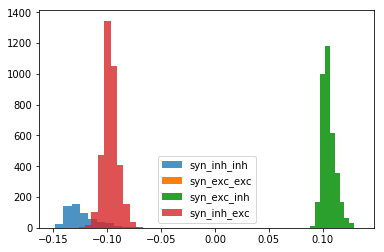

In [7]:
plt.hist(syn_inh_inh.get("weight", format="list",
                         with_address=False), label='syn_inh_inh', alpha=.8)
plt.hist(syn_exc_exc.get("weight", format="list",
                         with_address=False), label='syn_exc_exc')
plt.hist(syn_exc_inh.get("weight", format="list",
                         with_address=False), label='syn_exc_inh')
plt.hist(syn_inh_exc.get("weight", format="list",
                         with_address=False), label='syn_inh_exc', alpha=.8)
plt.legend()
plt.show()

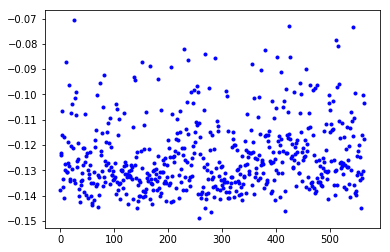

In [8]:
plt.plot(syn_inh_inh.get("weight", format="list",
                         with_address=False), '.b', label='syn_inh_inh')

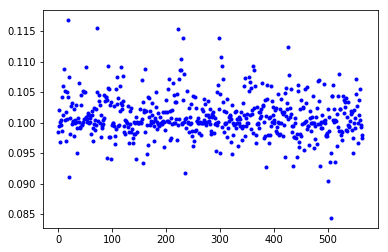

In [9]:
plt.plot(syn_exc_exc.get("weight", format="list",
                         with_address=False), '.b', label='syn_inh_inh')

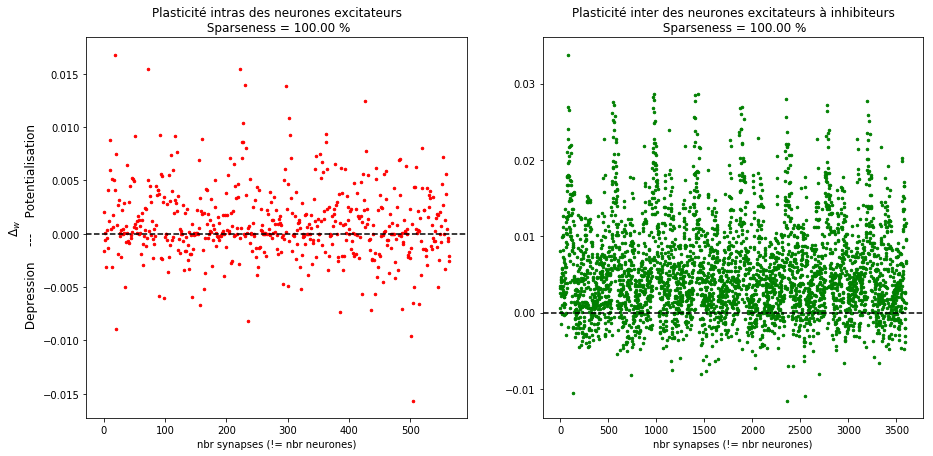

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

end_w = syn_exc_exc.get("weight", format="list", with_address=False)
delta_w = np.asarray(end_w) - stdp_weight_init

counts_null = 0
for weights in end_w:
    if weights == 0:
        counts_null += 1
sparseness = (1 - (counts_null/len(end_w))) * 100

axs[0].plot(delta_w, '.r', markersize=5)
axs[0].axhline(0, c='k', linestyle='--')
axs[0].set_xlabel('nbr synapses (!= nbr neurones)')
axs[0].set_ylabel(
    '$\Delta_w$\n Depression    ---    Potentialisation', fontsize=12)
axs[0].set_title(
    'Plasticité intras des neurones excitateurs\n Sparseness = %.2f %%' % sparseness)


end_w = syn_exc_inh.get("weight", format="list", with_address=False)
delta_w = np.asarray(end_w) - stdp_weight_init

counts_null = 0
for weights in end_w:
    if weights == 0:
        counts_null += 1
sparseness = (1 - (counts_null/len(end_w))) * 100

axs[1].plot(delta_w, '.g', markersize=5)
axs[1].axhline(0, c='k', linestyle='--')
plt.xlabel('nbr synapses (!= nbr neurones)')
plt.title('Plasticité inter des neurones excitateurs à inhibiteurs\n Sparseness = %.2f %%' % sparseness)
plt.show()
plt.pause(.1)